### Text Classification -- Ask Historians vs. Ask Science

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,classification

from yellowbrick.text import FreqDistVisualizer
from nltk.corpus import stopwords
import requests
import time
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re


### Data Acquisition

In [2]:
# create function to retrieve subreddit posts
def get_reddit_posts(subreddit, pages):
    url = "https://www.reddit.com/r/" + subreddit + ".json"
    headers = {'User-agent':'Time Bandit'}
    after = None
    posts = []
    for j in range(pages):
        if after==None:
            params = {}
        else:
            params = {'after':after}
        print(j)  # just to keep track of progress while it is running
        res = requests.get(url,params=params, headers=headers)
        if res.status_code==200:
            the_json = res.json()
            for i in range(len(the_json['data']['children'])):
                posts.append({'subreddit': the_json['data']['children'][i]['data']['subreddit'],
                                  'name':the_json['data']['children'][i]['data']['name'],
                                  'title':the_json['data']['children'][i]['data']['title'],
                              'text':the_json['data']['children'][i]['data']['selftext'],
                              'url':the_json['data']['children'][i]['data']['url'],
                                 'is_self': the_json['data']['children'][i]['data']['is_self']})
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(1)
    return pd.DataFrame(posts)    

In [3]:
# Get posts -- commented out so we don't re-run it.
# df=get_reddit_posts('AskHistorians',40)
# df.to_pickle('./data/askhistorians.pkl')

In [4]:
# read previously saved data
df_science = pd.read_pickle('./data/science.pkl')
df_historians = pd.read_pickle('./data/askhistorians.pkl')

### Data Cleaning

In [5]:
df = pd.concat([df_historians, df_science])
df = df.reset_index(drop=True)
df.subreddit.value_counts()

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


askscience       1656
AskHistorians     683
Name: subreddit, dtype: int64

In [6]:
df['is_self'].value_counts()

True    2339
Name: is_self, dtype: int64

In [7]:
# remove cases with blank text
df = df[df['text']!='']

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(1993, 7)

In [10]:
# calculate baseline
df.subreddit.value_counts(normalize=True)

askscience       0.657301
AskHistorians    0.342699
Name: subreddit, dtype: float64

In [11]:
df['text'] = df['title'] +' '+ df['text']

In [12]:
# Binarize label column
df['science'] = df['subreddit'].apply(lambda x: 1 if x == 'askscience' else 0)

# get rid of \n,  and &amp in text
df['text'] = df['text'].map(lambda x: x.replace('\n',' '))

df['text'] = df['text'].map(lambda x: x.replace('&amp;','and'))

In [13]:
# Load stopwords from NLTK and add custom words
mystopwords = stopwords.words('english')
mystopwords.extend(['like','would','get','x200b','https','one','www','com','org','etc','could'])

### Modeling: Logistic Regression

In [14]:
X = df['text']  # X will be turned into a matrix
y = df['science']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [15]:
# Logistic Regression model with Count Vectorizer
cvec = CountVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=1)

lr.fit(X_train_cvec, y_train)

print('Logistic Regression model with Count Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_cvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_cvec, y_test):.3f}')

Logistic Regression model with Count Vectorizer
Train score: 1.000
Test score: 0.940


In [16]:
# Logistic Regression model with TF-IDF Vectorizer
tvec = TfidfVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=50)

lr.fit(X_train_tvec, y_train)

print('Logistic Regression model with TF-IDF Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_tvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_tvec, y_test):.3f}')

Logistic Regression model with TF-IDF Vectorizer
Train score: 1.000
Test score: 0.962


### Modeling: Naive Bayes and SVM Models

In [17]:
# set up X, y for Naive Bayes and SVM Models
X = df[['text']]  # X is a pd Dataframe
y = df['science']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [18]:
cvec = CountVectorizer(stop_words=None,max_features=None,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.01)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Bernoulli model with Count Vectorizer
Train data accuracy: 0.999
Test data accuracy: 0.962


In [19]:
cvec = CountVectorizer(stop_words=None,max_features=4000,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=2)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Multinomial model with Count Vectorizer
Train data accuracy: 0.993
Test data accuracy: 0.962


In [20]:
tvec = TfidfVectorizer(stop_words=None,max_features=3000,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.1)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Multinomial model with TF-IDF Vectorizer
Train data accuracy: 0.994
Test data accuracy: 0.966


### Analyze Best Model Results

In [21]:
# print confusion matrix
y_pred = nb.predict(X_test_tvec)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

,predict neg,predict pos
actual neg,161,10
actual pos,7,321


In [22]:
# add predicted and actual y to test dataset
X_test['y_test'] = pd.Series(y_test, index=X_test.index)
X_test['y_pred'] = pd.Series(y_pred, index=X_test.index)

import re
# count words in text
X_test['word_count'] = pd.Series([len(re.findall(r'\w+', x)) for x in X_test.text], index=X_test.index)

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [23]:
# list false positives - predicted Science but actually History
mask = (X_test['y_test']==0) & (X_test['y_pred'] ==1)
print('Predicted Science but actually History')
for i in X_test[mask].index:
    print(f'Row {i}: {X_test.text.loc[i]}')
    print('-------------------------------------------------------------------')

Predicted Science but actually History
Row 378: Could someone from the 16th century survive the viruses and pathogens of modern day? If someone was brought from the 1500’s to now, could they survive all of the viruses, diseases, and crap that we have today?  Could someone from the 16th century survive the viruses and pathogens of modern day?
-------------------------------------------------------------------
Row 35: Does all human knowledge of the Pleistocene Megafauna come from the fossil record? To explain, it wasn't that long ago that humans walked alongside mammoths and smilodons. Is there any sort of evidence that humans from early civilization had any knowledge of these animals, through oral tradition or whatever? Does all human knowledge of the Pleistocene Megafauna come from the fossil record?
-------------------------------------------------------------------
Row 242: Cool Historian Careers? Hey!  What are some of the coolest careers someone with a history degree (or a master'

In [24]:
# list false negatives - predicted History but actually Science
mask = (X_test['y_test']==1) & (X_test['y_pred'] ==0)
print('Predicted History but actually Science')
for i in X_test[mask].index:
    print(f'Row {i}: {X_test.text.loc[i]}')
    print('-------------------------------------------------------------------')

Predicted History but actually Science
Row 1996: What makes things flammable? I've never really thought about it, but what makes things catch fire? I just thought about it while studying: in this specific case I was reading about local anesthetics and a note said "addition of alogena (F, Br, Cl) rise lipofilia and reduce flammability". I know some substances are flammable, I've never thought about the why though (except for some cases). Please forgive me if some terms are written wrong, while English is my native language I've been living/studying in a non English speaking country for most of my life
-------------------------------------------------------------------
Row 1256: Why do most North American hurricanes originating off the western coast of Africa move east to west? In the US, the jet stream, for the most part, flows from west to east....as does most of the weather.  But during hurricane season, all of the storms seem to form off of the African coast, and then head our way.  

In [27]:
tvec = TfidfVectorizer(stop_words=None,max_features=4000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.003)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Bernoulli model with TF-IDF Vectorizer
Train data accuracy: 0.997
Test data accuracy: 0.964


In [31]:
# SVM model
cvec = CountVectorizer(stop_words=mystopwords,max_features=800, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())
# Instantiate SVM.
# svc = svm.SVC(kernel='poly', C = 1.8, gamma = .05) 
svc = svm.SVC(kernel='rbf', C = 15, gamma = .02)  

# Fit on training data.
svc.fit(X_train_cvec,y_train)

# Score model on the training set.
print('Support Vector Machine model with Count Vectorizer')
print(f'Train data accuracy: {svc.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {svc.score(X_test_cvec,y_test):.3f}')

Support Vector Machine model with Count Vectorizer
Train data accuracy: 0.998
Test data accuracy: 0.912


### Data Visualization and EDA

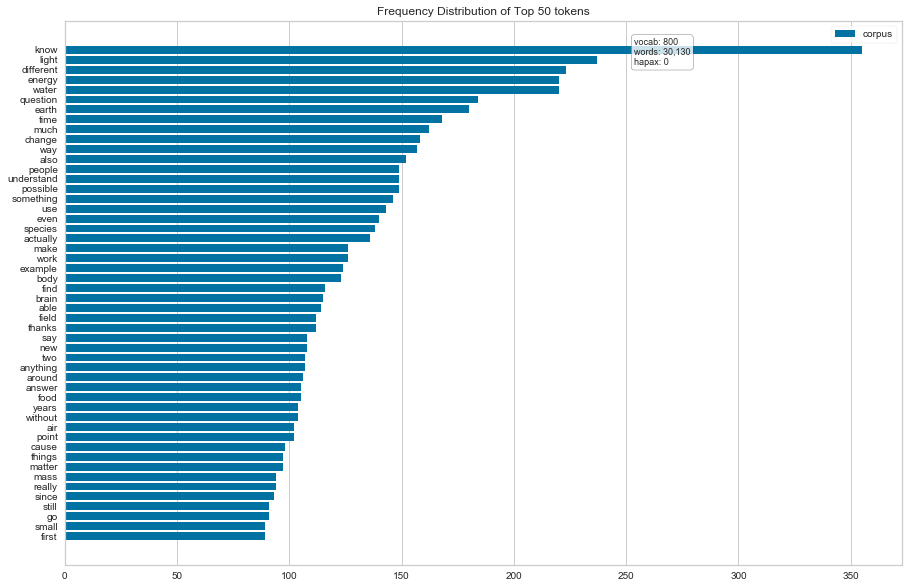

In [32]:
# https://www.scikit-yb.org/en/latest/api/text/freqdist.html
mask       = (df['science'] == 1)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50,)
visualizer.fit(docs)
visualizer.poof()

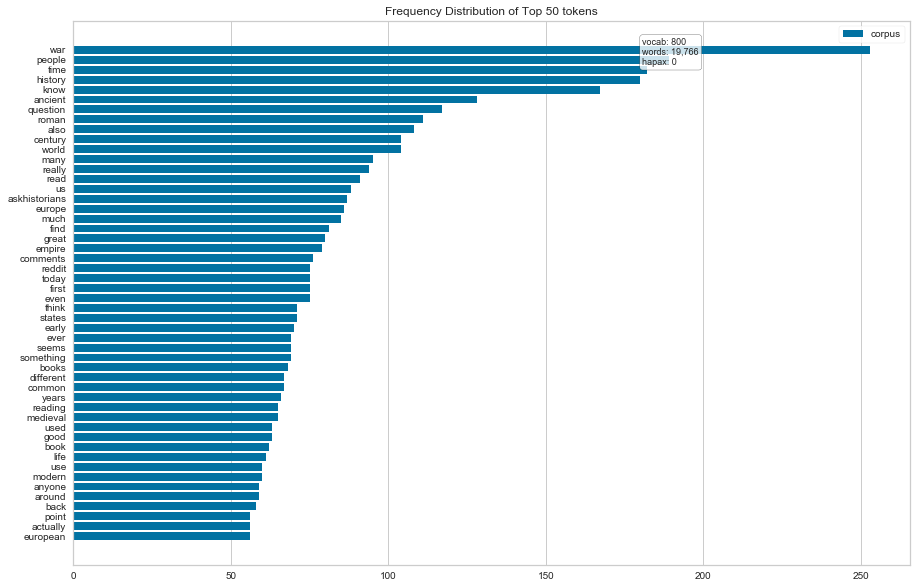

In [33]:
mask       = (df['science'] == 0)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50,kwargs={'color':'r'})
visualizer.fit(docs)
visualizer.poof()

In [34]:
# Define function to create wordclouds
def make_wc(mask):
    # use visualizer to create word frequency list for Wordcloud
    # (it is also possible to let wordcloud create the list)
    docs       = cvec.fit_transform(text for text in df['text'][mask])
    features   = cvec.get_feature_names()
    #create dataframe of word frequencies
    word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
    word_freq = word_freq.sort_values(by = ['freq'],ascending=False)
    # convert df into dict
    w_dict = dict([(word_freq['word'].iloc[i],word_freq['freq'].iloc[i]) for i in range(len(word_freq))])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1000,height=500,scale=1,background_color="white").generate_from_frequencies(w_dict)
    # Display the generated image:
    plt.rcParams['figure.figsize'] = (20, 10)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()
    return fig

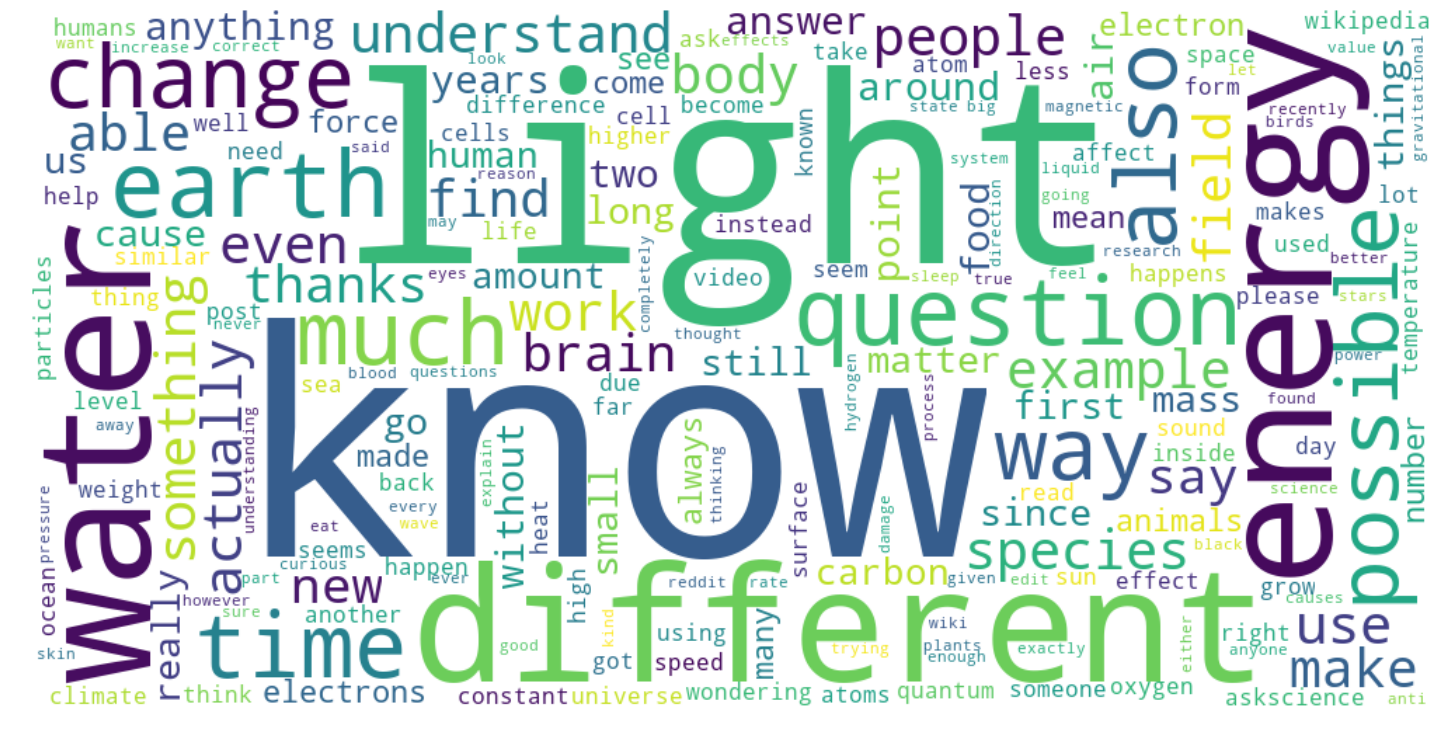

In [35]:
# make science wordcloud
mask = (df['science'] == 1)  # select which subreddit to use
name = 'science'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');

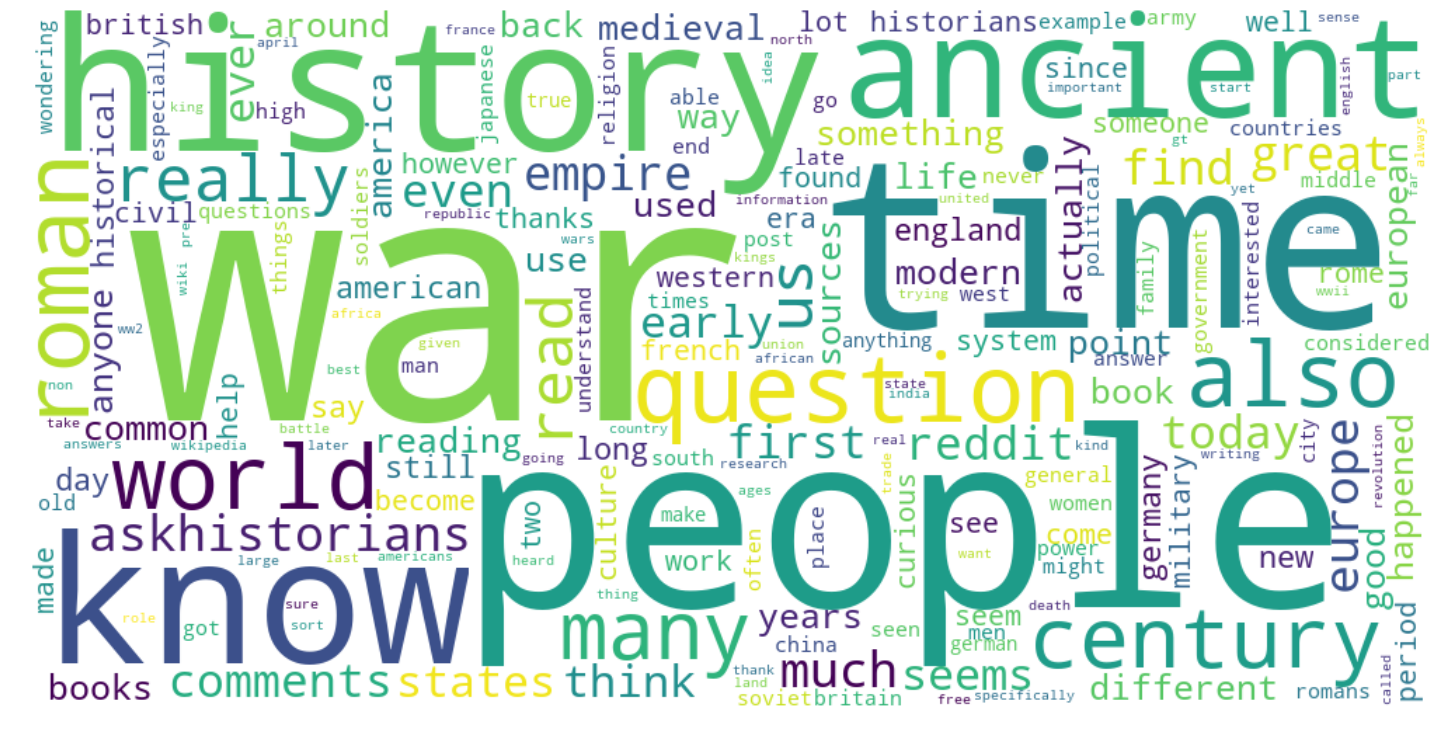

In [36]:
# make history wordcloud
mask = (df['science'] == 0)  # select which subreddit to use
name = 'history'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');